# Movie Genre-Based Clustering Analysis
Clustering movies based on genre attributes to evaluate different clustering algorithms and their effectiveness in grouping similar genre patterns.

## 1. Import Libraries
Import essential libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), machine learning preprocessing (StandardScaler, MultiLabelBinarizer), clustering algorithms (KMeans, Hierarchical, DBSCAN), and evaluation metrics (silhouette score, Davies-Bouldin, Calinski-Harabasz).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [2]:
# Load datasets
movies_df = pd.read_csv('../datasets/rotten_tomatoes_movies.csv')

# Select relevant columns
movies_df = movies_df[['rotten_tomatoes_link', 'movie_title', 'genres', 'tomatometer_rating', 'audience_rating']]

print(f"Loaded {movies_df.shape[0]} movies")

Loaded 17712 movies


## 3. Data Cleaning

In [3]:
# Remove rows with missing critical columns
movies_cleaned = movies_df.dropna(subset=['movie_title', 'genres', 'tomatometer_rating', 'audience_rating']).copy()

# Remove duplicates based on movie title
movies_cleaned = movies_cleaned.drop_duplicates(subset=['movie_title'], keep='first')

print(f"Cleaned data: {movies_df.shape[0]} rows → {movies_cleaned.shape[0]} unique movies")
print(f"Missing values: {movies_cleaned.isnull().sum().sum()} remaining")

Cleaned data: 17712 rows → 16798 unique movies
Missing values: 0 remaining


## 4. Genre Feature Engineering
Prepare genre features for clustering by splitting and cleaning the genre strings, encoding them into binary features using MultiLabelBinarizer, and aligning the processed features with the main movie data. This enables effective clustering based on genre combinations.

In [4]:
# Process genres - split by comma and clean
movies_cleaned['genres_list'] = movies_cleaned['genres'].str.split(',').apply(
    lambda x: [g.strip() for g in x] if isinstance(x, list) else []
)

# Encode genres using MultiLabelBinarizer (binary encoding)
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies_cleaned['genres_list'])

# Create genre feature matrix with fresh index
genre_features_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

print(f"Genre encoding complete:")
print(f"  Total genres: {len(mlb.classes_)}")
print(f"  Genre features shape: {genre_features_df.shape}")
print(f"  Genres: {list(mlb.classes_)}")

# Store for clustering - MUST reset index to align with genre_features_df
movie_data = movies_cleaned[['movie_title', 'genres', 'tomatometer_rating', 'audience_rating']].reset_index(drop=True).copy()
print(f"\nFeature matrix ready: {len(movie_data)} movies x {len(mlb.classes_)} genre features")

Genre encoding complete:
  Total genres: 21
  Genre features shape: (16798, 21)
  Genres: ['Action & Adventure', 'Animation', 'Anime & Manga', 'Art House & International', 'Classics', 'Comedy', 'Cult Movies', 'Documentary', 'Drama', 'Faith & Spirituality', 'Gay & Lesbian', 'Horror', 'Kids & Family', 'Musical & Performing Arts', 'Mystery & Suspense', 'Romance', 'Science Fiction & Fantasy', 'Special Interest', 'Sports & Fitness', 'Television', 'Western']

Feature matrix ready: 16798 movies x 21 genre features


## 5. Feature Preparation for Clustering
Prepare the feature matrix for clustering by selecting only the binary genre features and standardizing them using StandardScaler. This ensures all features contribute equally to the clustering algorithms.

In [5]:
# Use ONLY genre features for pure genre clustering
clustering_features = genre_features_df.copy()

print(f"Clustering features: {clustering_features.shape}")
print(f"Using: {clustering_features.shape[1]} binary genre features only")

# Standardize features for Euclidean-based algorithms
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

print(f"\nFeature preparation complete")
print(f"  Scaled features shape: {clustering_features_scaled.shape}")

Clustering features: (16798, 21)
Using: 21 binary genre features only

Feature preparation complete
  Scaled features shape: (16798, 21)


## 6. K-Means Clustering with Elbow Method
Apply the K-Means clustering algorithm to the standardized genre features. Use the Elbow Method to determine the optimal number of clusters by evaluating metrics such as inertia, silhouette score, Davies-Bouldin score, and Calinski-Harabasz score for different values of k.

In [6]:
# Use Elbow Method for optimal k selection
# k_max justified by genre combinations: with 21 base genres, most movies have 2-3 genres
# Common combinations: Drama+Mystery, Action+Thriller, Comedy+Romance, etc.
# Reasonable upper bound: 15 clusters to capture major genre combinations
k_range = range(5, 17)

print(f"Testing k={k_range[0]} to {k_range[-1]} ...\n")
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []
kmeans_models = []  # Store models to reuse the best one

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
    labels = kmeans.fit_predict(clustering_features_scaled)
    
    # Standard sklearn metrics
    sil = silhouette_score(clustering_features_scaled, labels)
    db = davies_bouldin_score(clustering_features_scaled, labels)
    ch = calinski_harabasz_score(clustering_features_scaled, labels)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)
    kmeans_models.append(kmeans)

# Select k with best silhouette score (no loop output, cleaner)
optimal_idx = np.argmax(silhouette_scores)
optimal_k = k_range[optimal_idx]
best_sil = silhouette_scores[optimal_idx]
best_kmeans = kmeans_models[optimal_idx]  # Reuse the already fitted model

# Use the already fitted model (no need to re-run clustering)
cluster_labels = best_kmeans.labels_

# Add cluster assignments to data
movie_data['cluster'] = cluster_labels


# Cluster size distribution with genre combinations
print(f"\nCluster Profiles with Genre Combinations:")
for cluster_id in sorted(movie_data['cluster'].unique()):
    cluster_movies = movie_data[movie_data['cluster'] == cluster_id]
    count = len(cluster_movies)
    pct = (count / len(movie_data)) * 100
    top_genre_combos = cluster_movies['genres'].value_counts().head(3)
    
    print(f"\n  Cluster {cluster_id}: {count:5,} movies ({pct:5.1f}%)")
    print(f"    Top genre combinations:")
    for genre_combo, combo_count in top_genre_combos.items():
        combo_pct = (combo_count / count) * 100
        print(f"      - {genre_combo}: {combo_count} movies ({combo_pct:.1f}%)")

Testing k=5 to 16 ...


Cluster Profiles with Genre Combinations:

  Cluster 0: 1,563 movies (  9.3%)
    Top genre combinations:
      - Action & Adventure, Drama: 341 movies (21.8%)
      - Action & Adventure, Drama, Mystery & Suspense: 308 movies (19.7%)
      - Action & Adventure, Mystery & Suspense: 205 movies (13.1%)

  Cluster 1: 4,040 movies ( 24.1%)
    Top genre combinations:
      - Drama: 1794 movies (44.4%)
      - Drama, Mystery & Suspense: 691 movies (17.1%)
      - Documentary: 458 movies (11.3%)

  Cluster 2:   852 movies (  5.1%)
    Top genre combinations:
      - Documentary, Musical & Performing Arts: 150 movies (17.6%)
      - Documentary, Musical & Performing Arts, Special Interest: 109 movies (12.8%)
      - Drama, Musical & Performing Arts: 75 movies (8.8%)

  Cluster 3:   287 movies (  1.7%)
    Top genre combinations:
      - Action & Adventure, Drama, Western: 27 movies (9.4%)
      - Action & Adventure, Western: 26 movies (9.1%)
      - Action & Adventure, 

### Elbow Method and Optimal k Selection
Visualize the results of the Elbow Method and silhouette scores to select the optimal number of clusters for K-Means. Also, display the distribution of cluster sizes for the chosen k.

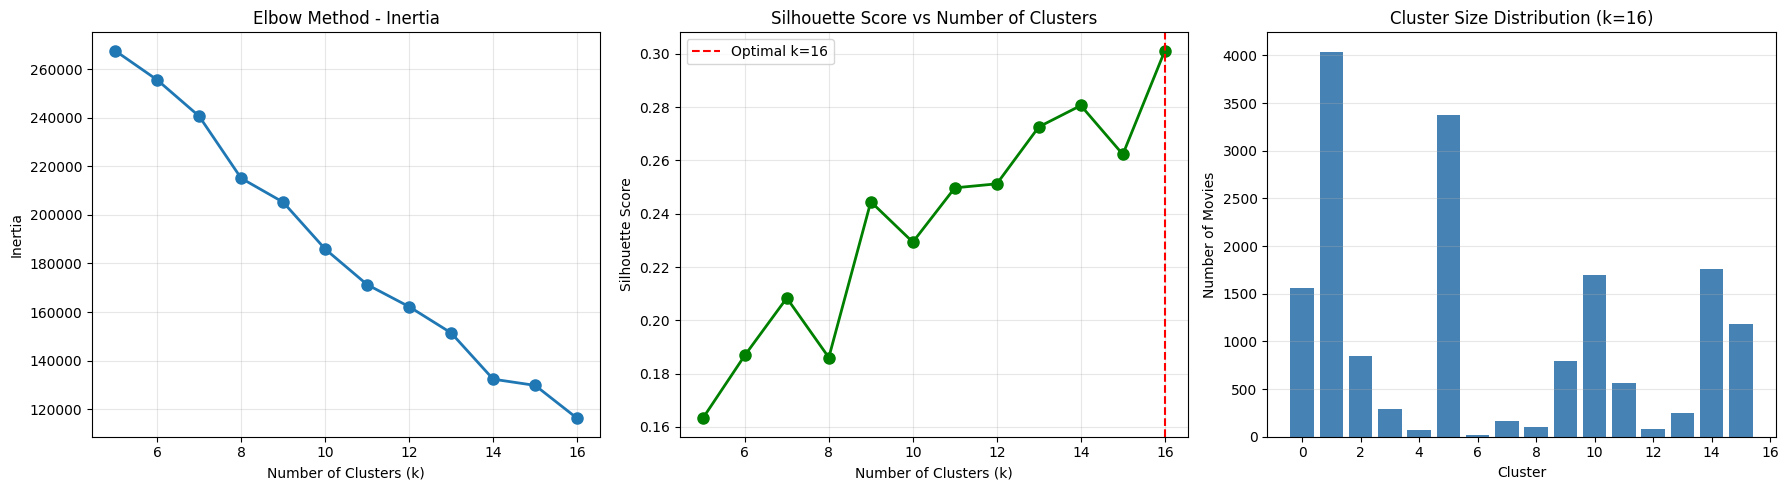


Optimal k=16 with silhouette score=0.301


In [7]:
# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Elbow curve (Inertia)
axes[0].plot(list(k_range), inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method - Inertia')
axes[0].grid(True, alpha=0.3)

# Plot 2: Silhouette scores
axes[1].plot(list(k_range), silhouette_scores, marker='o', color='green', linewidth=2, markersize=8)
axes[1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Cluster size distribution
cluster_counts = movie_data['cluster'].value_counts().sort_index()
axes[2].bar(cluster_counts.index, cluster_counts.values, color='steelblue')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Number of Movies')
axes[2].set_title(f'Cluster Size Distribution (k={optimal_k})')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nOptimal k={optimal_k} with silhouette score={best_sil:.3f}")

### Cluster Stability Testing
Evaluate the stability of the clustering solution by running K-Means multiple times with different random initializations. Calculate silhouette scores and cluster assignment consistency (Adjusted Rand Index) to assess how robust the clusters are to random seed changes.

In [8]:
# Test clustering stability with different random initializations
print("Cluster Stability Analysis:")
print("="*60)

n_runs = 30
stability_scores = []
cluster_assignments = []

for run in range(n_runs):
    kmeans_test = KMeans(n_clusters=optimal_k, random_state=run, n_init=10, init='k-means++')
    labels = kmeans_test.fit_predict(clustering_features_scaled)
    sil = silhouette_score(clustering_features_scaled, labels)
    stability_scores.append(sil)
    cluster_assignments.append(labels)

# Statistical summary of stability (print exactly once)
mean_sil = np.mean(stability_scores)
std_sil = np.std(stability_scores)
min_sil = np.min(stability_scores)
max_sil = np.max(stability_scores)

print(f"\nSilhouette Score Statistics (over {n_runs} runs):")
print(f"  Mean: {mean_sil:.4f}")
print(f"  Std Dev: {std_sil:.4f}")
print(f"  Min: {min_sil:.4f}")
print(f"  Max: {max_sil:.4f}")
print(f"  Coefficient of Variation: {(std_sil/mean_sil)*100:.2f}%")

# Measure cluster assignment consistency using Adjusted Rand Index (ARI)
from sklearn.metrics import adjusted_rand_score

ari_scores = []
base_labels = cluster_assignments[0]
for labels in cluster_assignments[1:]:
    ari_scores.append(adjusted_rand_score(base_labels, labels))

mean_ari = np.mean(ari_scores)
print(f"\nCluster Assignment Consistency (Adjusted Rand Index):")
print(f"  Mean ARI: {mean_ari:.4f}")
print(f"  Interpretation: {mean_ari:.2%} agreement between runs")

# Single stability assessment summary
if std_sil < 0.01 and mean_ari > 0.9:
    print("\nStability Assessment: EXCELLENT - Clusters are highly stable")
elif std_sil < 0.02 and mean_ari > 0.8:
    print("\nStability Assessment: GOOD - Clusters are reasonably stable")
else:
    print("\nStability Assessment: MODERATE - Some variability in cluster assignments")

Cluster Stability Analysis:

Silhouette Score Statistics (over 30 runs):
  Mean: 0.3113
  Std Dev: 0.0082
  Min: 0.2817
  Max: 0.3213
  Coefficient of Variation: 2.63%

Cluster Assignment Consistency (Adjusted Rand Index):
  Mean ARI: 0.5699
  Interpretation: 56.99% agreement between runs

Stability Assessment: MODERATE - Some variability in cluster assignments


### Cluster Stability Visualization

Visualizes the results of the cluster stability analysis performed in the previous cell. It shows the distribution of silhouette scores across multiple K-Means runs and the variation of these scores, helping to assess the robustness and consistency of the clustering solution.

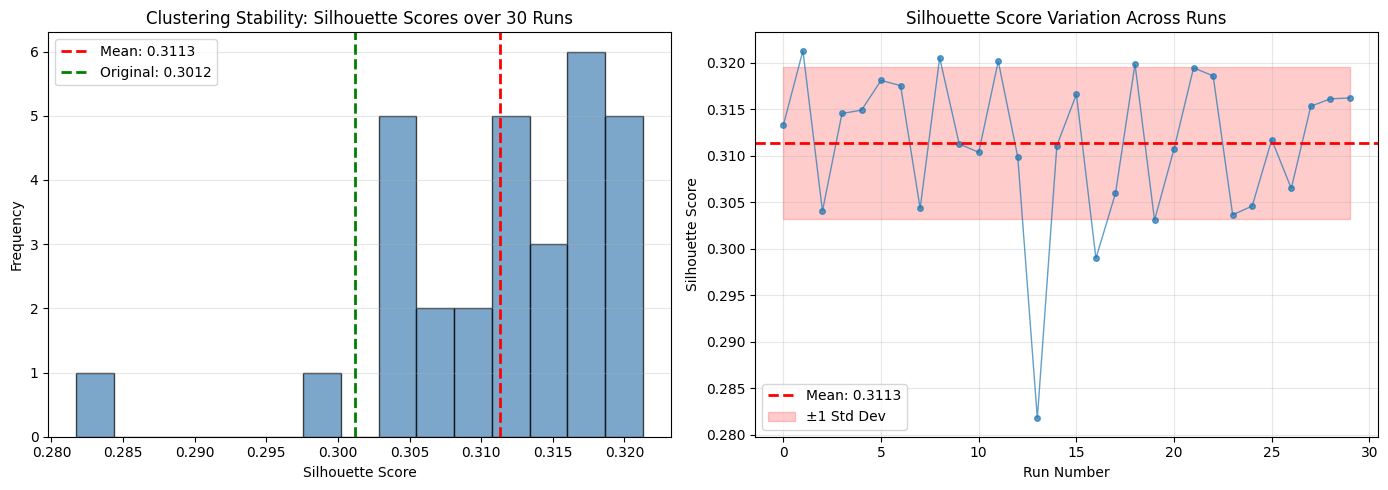

In [9]:
# Visualize stability results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of silhouette scores across runs
axes[0].hist(stability_scores, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(mean_sil, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sil:.4f}')
axes[0].axvline(best_sil, color='green', linestyle='--', linewidth=2, label=f'Original: {best_sil:.4f}')
axes[0].set_xlabel('Silhouette Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Clustering Stability: Silhouette Scores over {n_runs} Runs')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Silhouette scores across runs
axes[1].plot(range(n_runs), stability_scores, marker='o', linewidth=1, markersize=4, alpha=0.7)
axes[1].axhline(mean_sil, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sil:.4f}')
axes[1].fill_between(range(n_runs), mean_sil - std_sil, mean_sil + std_sil, 
                      alpha=0.2, color='red', label=f'±1 Std Dev')
axes[1].set_xlabel('Run Number')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Variation Across Runs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Variance Analysis

Performs a variance decomposition analysis on the clustering results. It calculates the total variance, within-cluster variance, and between-cluster variance to assess how well the clusters are separated. The analysis also identifies the most and least compact clusters, providing insights into the quality and structure of the clustering solution.

Variance Analysis:

Variance Decomposition:
 Total Variance: 352758.00
 Within-Cluster Variance (WSS): 116259.28
 Between-Cluster Variance (BSS): 236498.72
 BSS/TSS Ratio: 67.04%

Between-to-Within Variance Ratio: 2.0342
 Interpretation: Good cluster separation (BSS > WSS)

Per-Cluster Variance Analysis:
 Cluster  Size  Variance  Avg_Distance_to_Center
       0  1563  5.941262                2.255913
       1  4040  5.367545                2.048065
       2   852 12.666884                3.431639
       3   287 10.407677                3.078412
       4    73 14.371056                3.238104
       5  3374  5.150712                2.019019
       6    19 14.252399                3.566602
       7   163 11.608058                3.177036
       8   102 19.438817                4.193076
       9   793  3.599303                1.369088
      10  1697  6.736385                2.404043
      11   566 12.379604                3.380455
      12    78 19.566148                4.051520
      13

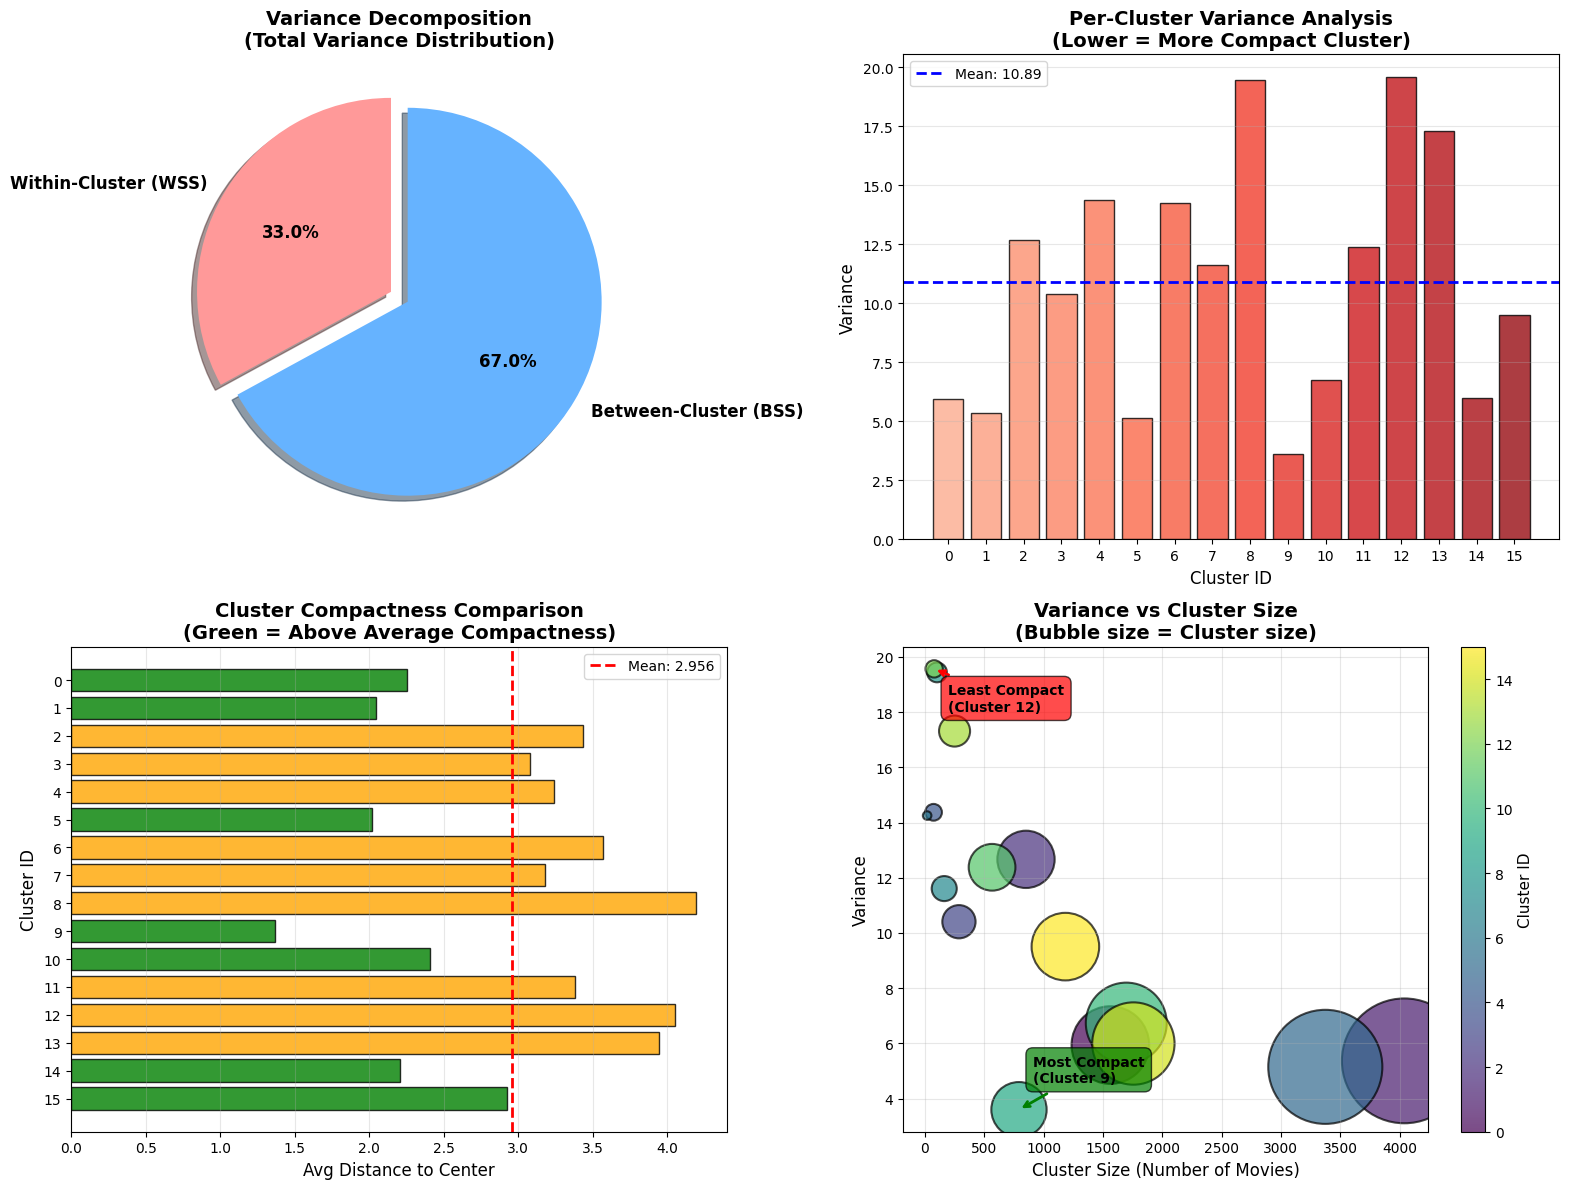


✅ Variance analysis visualization complete!


In [10]:
# Variance decomposition analysis
print("Variance Analysis:")
print("="*60)

# Calculate total variance
total_variance = np.var(clustering_features_scaled, axis=0).sum()

# Calculate within-cluster variance (sum of squared distances to centroids)
within_cluster_variance = best_kmeans.inertia_

# Calculate between-cluster variance
cluster_centers = best_kmeans.cluster_centers_
overall_center = clustering_features_scaled.mean(axis=0)
between_cluster_variance = 0
for i in range(optimal_k):
    cluster_size = np.sum(cluster_labels == i)
    center_diff = cluster_centers[i] - overall_center
    between_cluster_variance += cluster_size * np.sum(center_diff ** 2)

# Total variance check (should equal within + between)
total_variance_check = within_cluster_variance + between_cluster_variance

print(f"\nVariance Decomposition:")
print(f" Total Variance: {total_variance_check:.2f}")
print(f" Within-Cluster Variance (WSS): {within_cluster_variance:.2f}")
print(f" Between-Cluster Variance (BSS): {between_cluster_variance:.2f}")
print(f" BSS/TSS Ratio: {(between_cluster_variance/total_variance_check)*100:.2f}%")

# Variance ratio (higher is better - indicates well-separated clusters)
variance_ratio = between_cluster_variance / within_cluster_variance
print(f"\nBetween-to-Within Variance Ratio: {variance_ratio:.4f}")
if variance_ratio > 1:
    print(" Interpretation: Good cluster separation (BSS > WSS)")
else:
    print(" Interpretation: Moderate cluster separation (BSS < WSS)")

# Per-cluster variance analysis
print(f"\nPer-Cluster Variance Analysis:")
cluster_variances = []
for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_data = clustering_features_scaled[cluster_mask]
    if len(cluster_data) > 1:
        cluster_var = np.var(cluster_data, axis=0).sum()
        cluster_variances.append({
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Variance': cluster_var,
            'Avg_Distance_to_Center': np.mean(
                np.linalg.norm(cluster_data - cluster_centers[cluster_id], axis=1)
            )
        })

variance_df = pd.DataFrame(cluster_variances)
print(variance_df.to_string(index=False))

# Identify most and least compact clusters
most_compact = variance_df.loc[variance_df['Variance'].idxmin()]
least_compact = variance_df.loc[variance_df['Variance'].idxmax()]
print(f"\nMost Compact Cluster: {int(most_compact['Cluster'])} (variance: {most_compact['Variance']:.2f})")
print(f"Least Compact Cluster: {int(least_compact['Cluster'])} (variance: {least_compact['Variance']:.2f})")

# Visualizations
print("\n" + "="*60)
print("Generating Variance Analysis Visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Variance Decomposition (Pie Chart)
ax1 = axes[0, 0]
variance_components = [within_cluster_variance, between_cluster_variance]
labels = ['Within-Cluster (WSS)', 'Between-Cluster (BSS)']
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)
ax1.pie(
    variance_components, labels=labels, autopct='%1.1f%%',
    startangle=90, colors=colors, explode=explode, shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
ax1.set_title('Variance Decomposition\n(Total Variance Distribution)', fontsize=14, fontweight='bold')

# Plot 2: Per-Cluster Variance (Bar Chart)
ax2 = axes[0, 1]
cluster_ids_var = variance_df['Cluster'].astype(int)
variances = variance_df['Variance']
colors_var = plt.cm.Reds(np.linspace(0.3, 0.9, len(cluster_ids_var)))
ax2.bar(cluster_ids_var, variances, color=colors_var, alpha=0.8, edgecolor='black')
ax2.axhline(y=variances.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {variances.mean():.2f}')
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Variance', fontsize=12)
ax2.set_title('Per-Cluster Variance Analysis\n(Lower = More Compact Cluster)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(cluster_ids_var)

# Plot 3: Average Distance to Center (Horizontal Bar)
ax3 = axes[1, 0]
avg_distances = variance_df['Avg_Distance_to_Center']
colors_dist = ['green' if d < avg_distances.mean() else 'orange' for d in avg_distances]
ax3.barh(cluster_ids_var, avg_distances, color=colors_dist, alpha=0.8, edgecolor='black')
ax3.axvline(x=avg_distances.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_distances.mean():.3f}')
ax3.set_ylabel('Cluster ID', fontsize=12)
ax3.set_xlabel('Avg Distance to Center', fontsize=12)
ax3.set_title('Cluster Compactness Comparison\n(Green = Above Average Compactness)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')
ax3.set_yticks(cluster_ids_var)
ax3.invert_yaxis()

# Plot 4: Variance vs Cluster Size (Scatter Plot)
ax4 = axes[1, 1]
cluster_sizes_var = variance_df['Size']
scatter = ax4.scatter(
    cluster_sizes_var, variances,
    s=cluster_sizes_var*2,
    c=cluster_ids_var, cmap='viridis', alpha=0.7,
    edgecolors='black', linewidth=1.5
)
ax4.set_xlabel('Cluster Size (Number of Movies)', fontsize=12)
ax4.set_ylabel('Variance', fontsize=12)
ax4.set_title('Variance vs Cluster Size\n(Bubble size = Cluster size)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Cluster ID', fontsize=11)

# Add text annotations for most/least compact clusters
ax4.annotate(
    f'Most Compact\n(Cluster {int(most_compact["Cluster"])})',
    xy=(most_compact['Size'], most_compact['Variance']),
    xytext=(10, 20), textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.7),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='green', lw=2),
    fontsize=10, fontweight='bold'
)
ax4.annotate(
    f'Least Compact\n(Cluster {int(least_compact["Cluster"])})',
    xy=(least_compact['Size'], least_compact['Variance']),
    xytext=(10, -30), textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.7),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', lw=2),
    fontsize=10, fontweight='bold'
)

plt.tight_layout()
plt.show()
print("\n✅ Variance analysis visualization complete!")

### Cluster Profiling and Characteristics

Analyzes the genre diversity and characteristics of each cluster. It calculates metrics such as the average number of genres per movie, genre diversity (entropy), and the number of unique genres in each cluster. The analysis helps to understand the internal structure and thematic diversity of the clusters formed by the clustering algorithm.

In [11]:
# Genre diversity analysis per cluster
print("Genre Diversity Analysis:")
print("="*60)

cluster_diversity = []

for cluster_id in range(optimal_k):
    cluster_mask = movie_data['cluster'] == cluster_id
    cluster_genre_features = genre_features_df[cluster_mask]
    
    # Calculate average number of genres per movie in cluster
    avg_genres = cluster_genre_features.sum(axis=1).mean()
    
    # Calculate genre diversity (Shannon entropy)
    genre_props = cluster_genre_features.sum(axis=0) / cluster_genre_features.sum().sum()
    genre_props = genre_props[genre_props > 0]  # Remove zero probabilities
    entropy = -np.sum(genre_props * np.log2(genre_props))
    
    # Number of unique genres in cluster
    num_genres = (cluster_genre_features.sum(axis=0) > 0).sum()
    
    cluster_diversity.append({
        'Cluster': cluster_id,
        'Unique Genres': num_genres,
        'Avg Genres/Movie': f"{avg_genres:.2f}",
        'Diversity (Entropy)': f"{entropy:.2f}"
    })

diversity_df = pd.DataFrame(cluster_diversity)
print("\n" + diversity_df.to_string(index=False))

# Identify most and least diverse clusters
most_diverse_idx = diversity_df['Diversity (Entropy)'].astype(float).idxmax()
least_diverse_idx = diversity_df['Diversity (Entropy)'].astype(float).idxmin()

print(f"\nMost Diverse Cluster: {diversity_df.loc[most_diverse_idx, 'Cluster']} (entropy: {diversity_df.loc[most_diverse_idx, 'Diversity (Entropy)']})")
print(f"Least Diverse Cluster: {diversity_df.loc[least_diverse_idx, 'Cluster']} (entropy: {diversity_df.loc[least_diverse_idx, 'Diversity (Entropy)']})")

print("\nNote: Higher entropy indicates more balanced genre distribution within cluster")

Genre Diversity Analysis:

 Cluster  Unique Genres Avg Genres/Movie Diversity (Entropy)
       0             10             2.50                2.24
       1              7             1.46                1.88
       2             13             3.00                2.97
       3             15             3.06                2.83
       4             15             3.07                2.88
       5              9             1.87                1.99
       6             12             4.47                3.01
       7             14             2.83                2.71
       8             17             3.76                3.35
       9             13             2.38                2.03
      10             12             2.26                2.50
      11             14             3.21                2.84
      12             16             3.21                3.02
      13             16             3.16                3.27
      14             12             2.78                2.

### Genre Distribution and Cluster Characterization Visualizations
Generates a heatmap showing the distribution of genres across all clusters, helping to identify which genres are most prevalent in each group. It also prints the dominant genre for each cluster.
Visualizes the top 5 genres for each cluster using bar plots, making it easy to compare the most common genres within each cluster. These visualizations help interpret the thematic composition and distinctiveness of each cluster.

Generating Genre Distribution Heatmap...


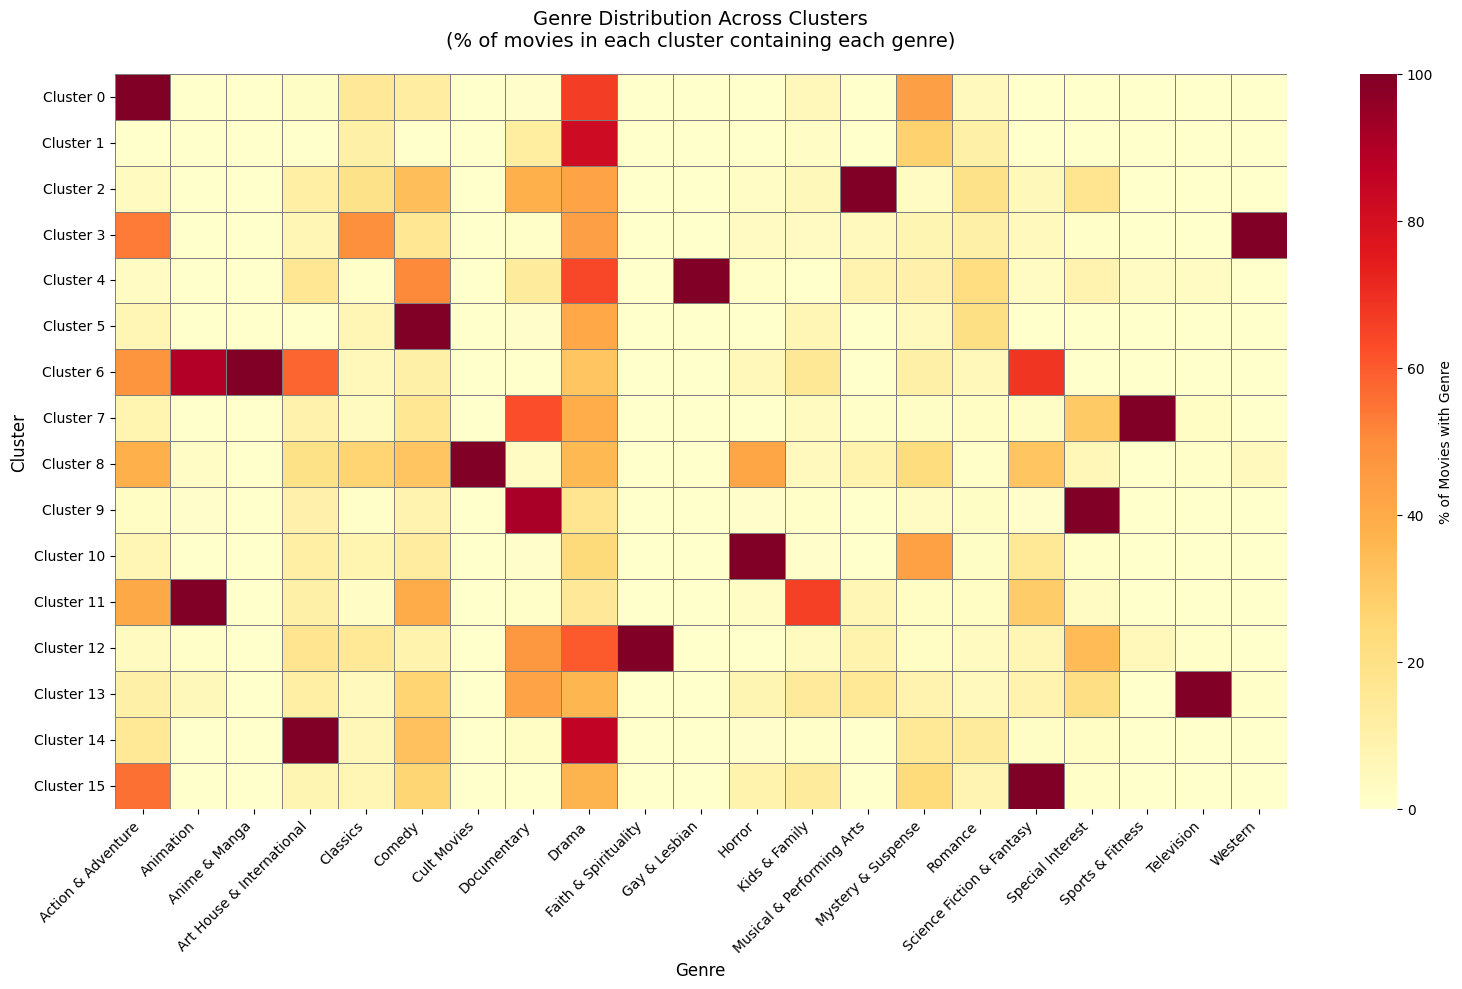

In [12]:
# Genre distribution heatmap across clusters
print("Generating Genre Distribution Heatmap...")

# Calculate cluster sizes
cluster_sizes = movie_data['cluster'].value_counts().to_dict()

# Create genre distribution matrix (cluster x genre)
genre_cluster_matrix = np.zeros((optimal_k, len(mlb.classes_)))

for cluster_id in range(optimal_k):
    cluster_mask = movie_data['cluster'] == cluster_id
    cluster_genre_features = genre_features_df[cluster_mask]
    
    # Calculate percentage of movies in this cluster that have each genre
    genre_cluster_matrix[cluster_id] = (cluster_genre_features.sum(axis=0) / cluster_genre_features.shape[0]) * 100

# Create DataFrame for better visualization
genre_dist_df = pd.DataFrame(
    genre_cluster_matrix,
    index=[f'Cluster {i}' for i in range(optimal_k)],
    columns=mlb.classes_
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(genre_dist_df, annot=False, cmap='YlOrRd', cbar_kws={'label': '% of Movies with Genre'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Genre Distribution Across Clusters\n(% of movies in each cluster containing each genre)', 
             fontsize=14, pad=20)
ax.set_xlabel('Genre', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



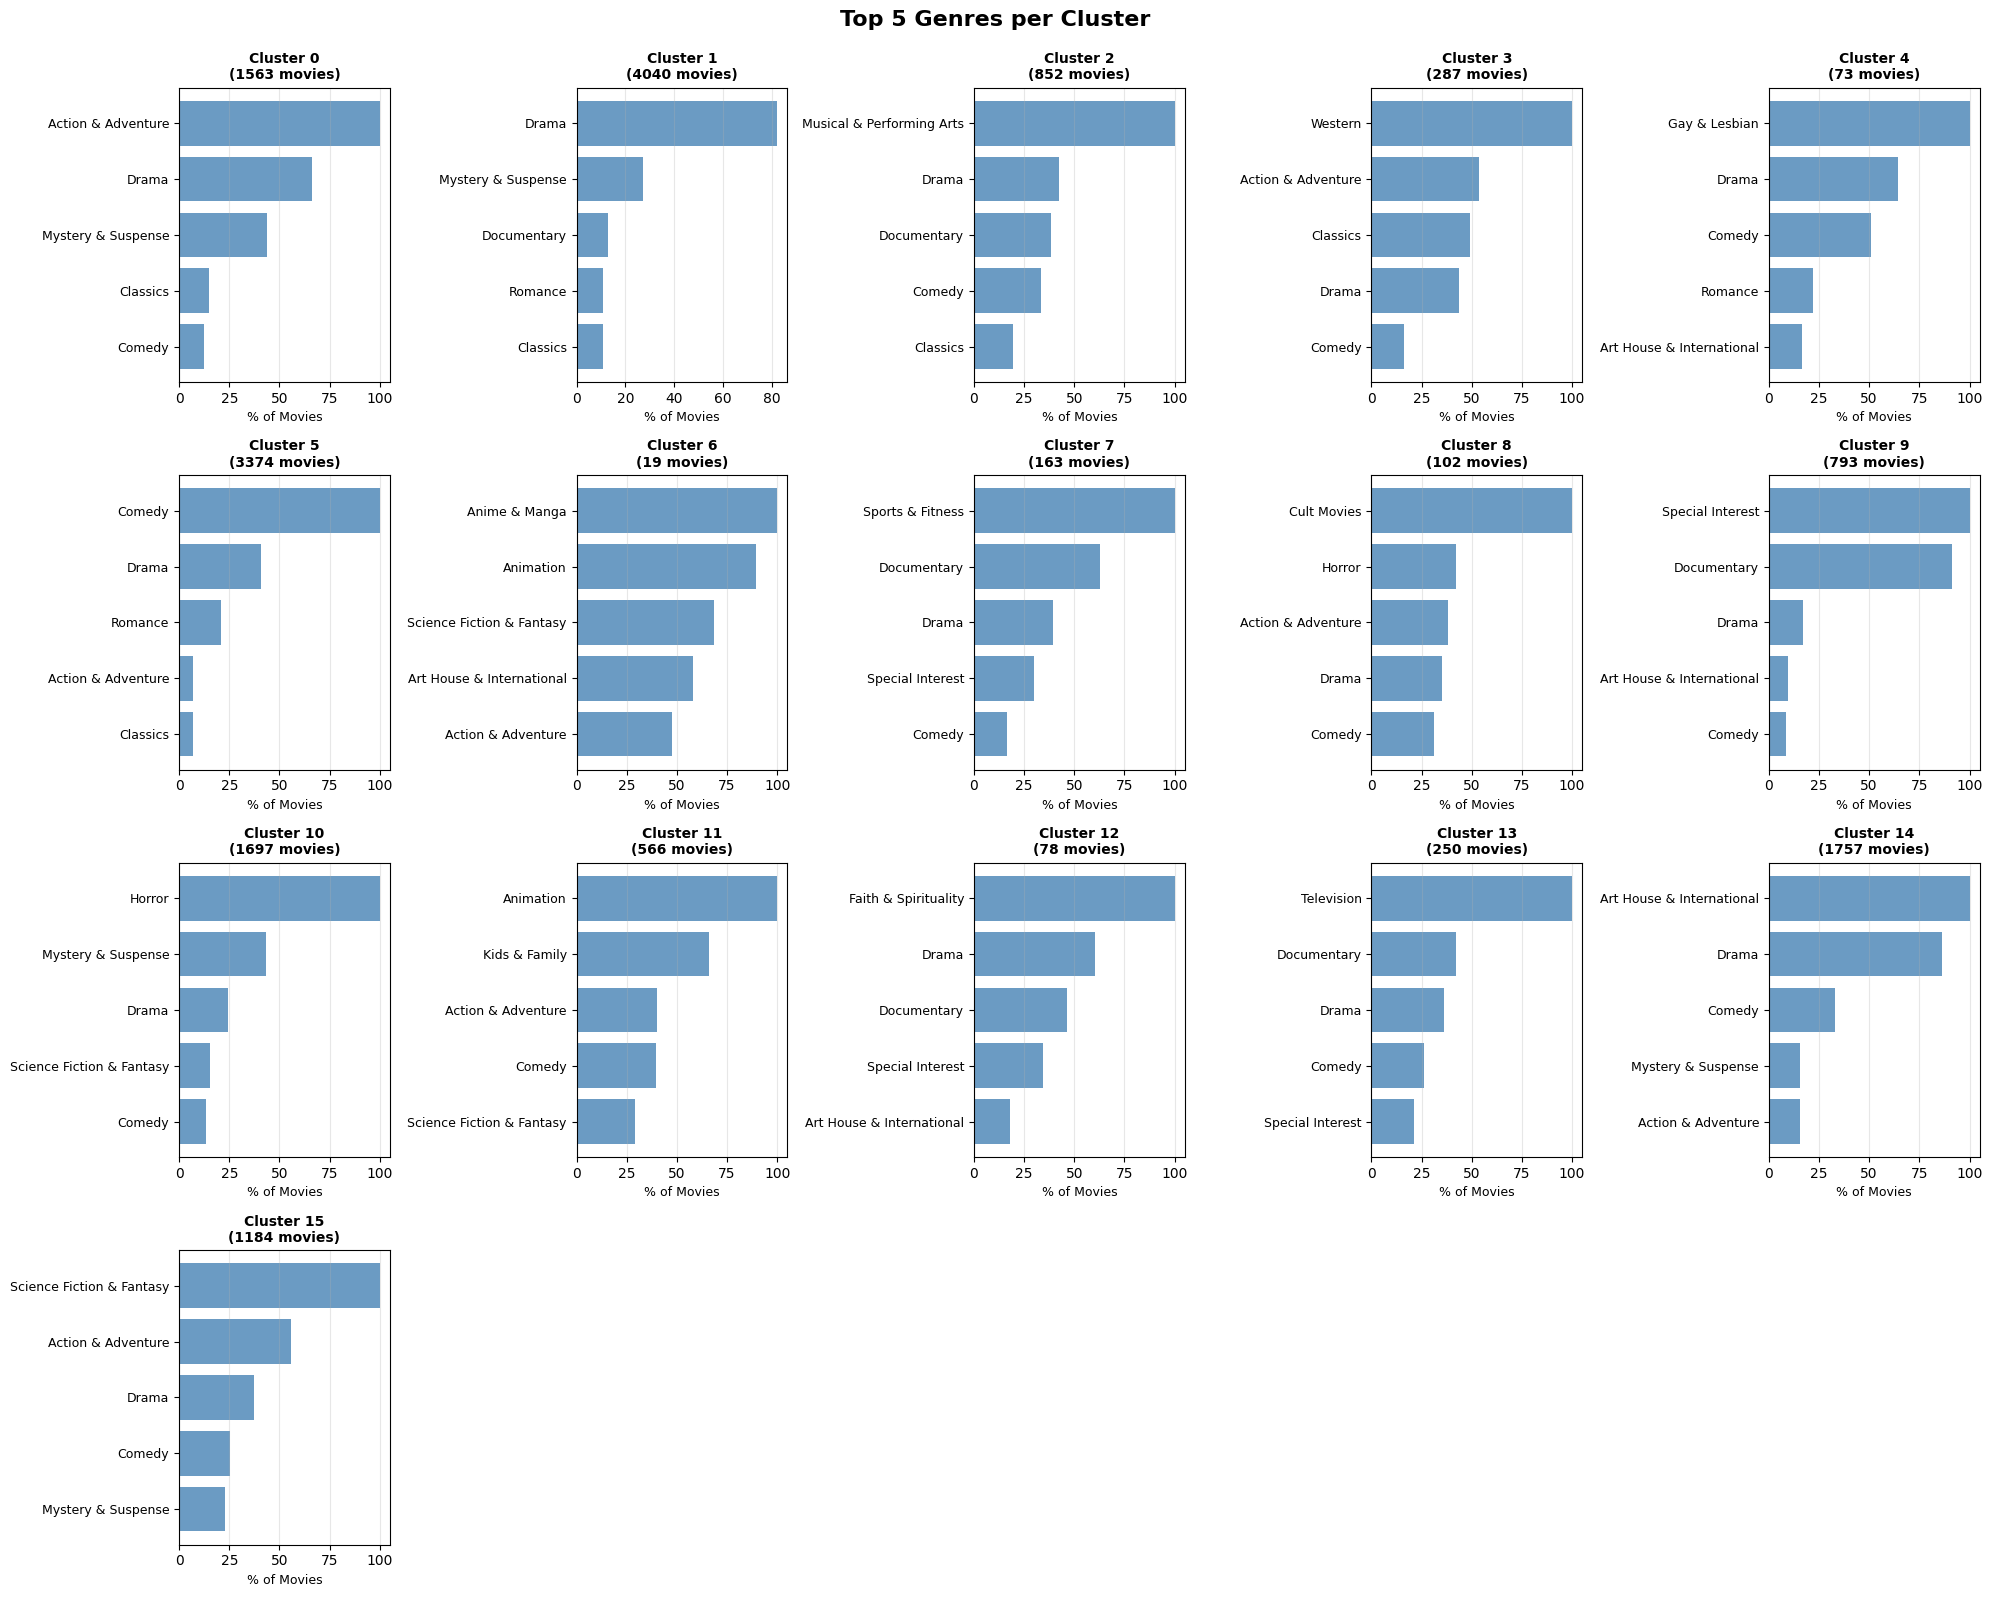

In [13]:
# Top genres per cluster visualization
# Dynamically calculate grid size based on number of clusters
n_cols = 5
n_rows = (optimal_k + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for cluster_id in range(optimal_k):
    # Get top 5 genres for this cluster
    cluster_genres = genre_dist_df.loc[f'Cluster {cluster_id}'].sort_values(ascending=False).head(5)
    
    ax = axes[cluster_id]
    ax.barh(range(len(cluster_genres)), cluster_genres.values, color='steelblue', alpha=0.8)
    ax.set_yticks(range(len(cluster_genres)))
    ax.set_yticklabels(cluster_genres.index, fontsize=9)
    ax.set_xlabel('% of Movies', fontsize=9)
    ax.set_title(f'Cluster {cluster_id}\n({cluster_sizes[cluster_id]} movies)', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

# Hide unused subplots
for idx in range(optimal_k, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Top 5 Genres per Cluster', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Cluster Characteristics Summary Table

This section generates a comprehensive summary table for each cluster, including:
- Cluster size and percentage of total movies
- Average audience and critic ratings
- Top 3 most common genres
- Cluster compactness (variance)
It also prints overall clustering statistics, helping to interpret the quality and characteristics of each cluster and the clustering solution as a whole.

Cluster Characteristics Summary:

 Cluster  Size Pct of Total Avg Audience Rating Avg Critic Rating                                         Top 3 Genres Compactness
       0  1563         9.3%                57.5              53.0        Action & Adventure, Drama, Mystery & Suspense        5.94
       1  4040        24.1%                63.4              65.2               Drama, Mystery & Suspense, Documentary        5.37
       2   852         5.1%                71.2              71.0        Musical & Performing Arts, Drama, Documentary       12.67
       3   287         1.7%                64.9              69.3                Western, Action & Adventure, Classics       10.41
       4    73         0.4%                61.6              57.6                         Gay & Lesbian, Drama, Comedy       14.37
       5  3374        20.1%                56.4              51.2                               Comedy, Drama, Romance        5.15
       6    19         0.1%                75.0  

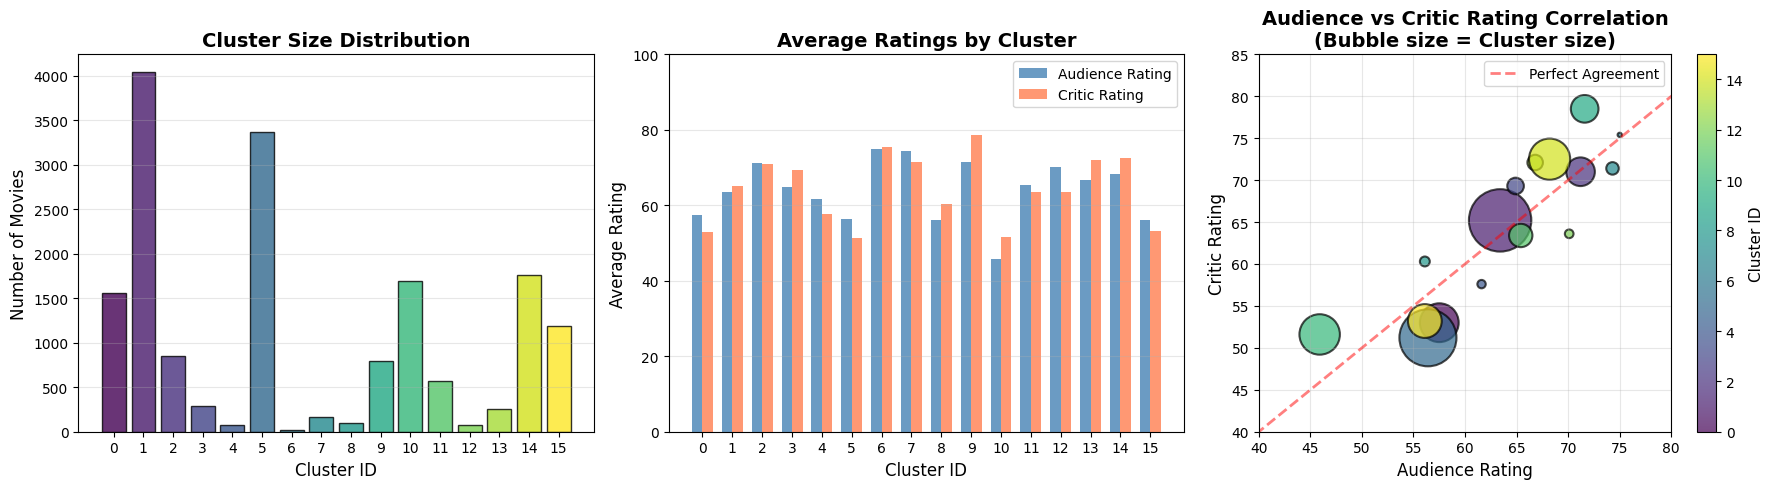


✅ Cluster characteristics visualization complete!


In [14]:
# Comprehensive cluster characteristics table
print("Cluster Characteristics Summary:")
print("="*80)

cluster_characteristics = []
for cluster_id in sorted(movie_data['cluster'].unique()):
    cluster_movies = movie_data[movie_data['cluster'] == cluster_id]

    # Get top 3 most common genres in this cluster
    all_genres = []
    for genres_str in cluster_movies['genres']:
        all_genres.extend([g.strip() for g in genres_str.split(',')])
    from collections import Counter
    genre_counts = Counter(all_genres)
    top_genres = [genre for genre, count in genre_counts.most_common(3)]
    top_genres_str = ', '.join(top_genres)

    cluster_characteristics.append({
        'Cluster': cluster_id,
        'Size': len(cluster_movies),
        'Pct of Total': f"{(len(cluster_movies)/len(movie_data)*100):.1f}%",
        'Avg Audience Rating': f"{cluster_movies['audience_rating'].mean():.1f}",
        'Avg Critic Rating': f"{cluster_movies['tomatometer_rating'].mean():.1f}",
        'Top 3 Genres': top_genres_str,
        'Compactness': f"{variance_df[variance_df['Cluster']==cluster_id]['Variance'].values[0]:.2f}"
    })

characteristics_df = pd.DataFrame(cluster_characteristics)
print("\n" + characteristics_df.to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("Overall Clustering Summary:")
print(f" Total Movies: {len(movie_data):,}")
print(f" Number of Clusters: {optimal_k}")
print(f" Average Cluster Size: {len(movie_data)/optimal_k:.0f} movies")
print(f" Largest Cluster: {characteristics_df.loc[characteristics_df['Size'].astype(int).idxmax(), 'Cluster']} ({characteristics_df['Size'].astype(int).max()} movies)")
print(f" Smallest Cluster: {characteristics_df.loc[characteristics_df['Size'].astype(int).idxmin(), 'Cluster']} ({characteristics_df['Size'].astype(int).min()} movies)")

# Visualizations
print("\n" + "="*80)
print("Generating Cluster Characteristics Visualizations...")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Cluster Size Distribution
ax1 = axes[0]
cluster_sizes_viz = characteristics_df['Size'].astype(int)
cluster_ids = characteristics_df['Cluster'].astype(int)
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_ids)))
ax1.bar(cluster_ids, cluster_sizes_viz, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Movies', fontsize=12)
ax1.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(cluster_ids)

# Plot 2: Average Ratings by Cluster
ax2 = axes[1]
audience_ratings = characteristics_df['Avg Audience Rating'].astype(float)
critic_ratings = characteristics_df['Avg Critic Rating'].astype(float)
x_pos = np.arange(len(cluster_ids))
width = 0.35
ax2.bar(x_pos - width/2, audience_ratings, width, label='Audience Rating', color='steelblue', alpha=0.8)
ax2.bar(x_pos + width/2, critic_ratings, width, label='Critic Rating', color='coral', alpha=0.8)
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax2.set_title('Average Ratings by Cluster', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cluster_ids)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 100)

# Plot 3: Rating Correlation (Audience vs Critic)
ax3 = axes[2]
scatter = ax3.scatter(
    audience_ratings, critic_ratings,
    s=cluster_sizes_viz*0.5,
    c=cluster_ids, cmap='viridis', alpha=0.7,
    edgecolors='black', linewidth=1.5
)
ax3.plot([0, 100], [0, 100], 'r--', alpha=0.5, linewidth=2, label='Perfect Agreement')
ax3.set_xlabel('Audience Rating', fontsize=12)
ax3.set_ylabel('Critic Rating', fontsize=12)
ax3.set_title('Audience vs Critic Rating Correlation\n(Bubble size = Cluster size)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(40, 80)
ax3.set_ylim(40, 85)

# Add colorbar for cluster IDs
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Cluster ID', fontsize=11)

plt.tight_layout()
plt.show()
print("\n✅ Cluster characteristics visualization complete!")


### Algorithm Performance Comparison

This section evaluates and compares three clustering approaches on the genre-based features:
- **K-Means:** Reuses the previously computed K-Means result (optimal k) and reports silhouette, Davies–Bouldin, and Calinski–Harabasz metrics.
- **Hierarchical (Agglomerative):** Tests the same k range and selects the hierarchical clustering with the best silhouette score.
- **DBSCAN:** Tries several `eps` values, filters reasonable candidates (>=2 clusters and <50% noise), and computes metrics on the non-noise points.

 assembles these results into a DataFrame, prints a comparison table, explains metric interpretation, and identifies the best algorithm based on the highest silhouette score.

In [15]:
# Compare K-Means, Hierarchical, and DBSCAN clustering algorithms
results = []

# 1. K-Means (already computed above)
km_sil = best_sil
km_db = db_scores[optimal_k - k_range[0]]
km_ch = ch_scores[optimal_k - k_range[0]]

results.append({
    'Algorithm': 'K-Means',
    'Clusters': optimal_k,
    'Silhouette': km_sil,
    'Davies-Bouldin': km_db,
    'Calinski-Harabasz': km_ch
})

# 2. Hierarchical Clustering (auto-select k)
print("\nEvaluating Hierarchical Clustering...")
hier_candidates = []
for k in k_range:
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hier.fit_predict(clustering_features_scaled)
    sil = silhouette_score(clustering_features_scaled, labels)
    hier_candidates.append({'k': k, 'labels': labels, 'sil': sil})

best_hier = max(hier_candidates, key=lambda x: x['sil'])
hier_labels = best_hier['labels']

results.append({
    'Algorithm': 'Hierarchical',
    'Clusters': best_hier['k'],
    'Silhouette': best_hier['sil'],
    'Davies-Bouldin': davies_bouldin_score(clustering_features_scaled, hier_labels),
    'Calinski-Harabasz': calinski_harabasz_score(clustering_features_scaled, hier_labels)
})

# 3. DBSCAN (auto-select eps)
print("Evaluating DBSCAN...")
dbscan_candidates = []
for eps in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    db_model = DBSCAN(eps=eps, min_samples=10)
    labels = db_model.fit_predict(clustering_features_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_pct = list(labels).count(-1) / len(labels) * 100
    
    if n_clusters >= 2 and noise_pct < 50:
        mask = labels != -1
        sil = silhouette_score(clustering_features_scaled[mask], labels[mask])
        dbscan_candidates.append({
            'eps': eps, 'clusters': n_clusters, 'labels': labels,
            'sil': sil, 'noise': noise_pct, 'mask': mask
        })

if dbscan_candidates:
    best_db = max(dbscan_candidates, key=lambda x: x['sil'])
    mask = best_db['mask']
    db_labels = best_db['labels']
    
    results.append({
        'Algorithm': 'DBSCAN',
        'Clusters': best_db['clusters'],
        'Silhouette': best_db['sil'],
        'Davies-Bouldin': davies_bouldin_score(clustering_features_scaled[mask], db_labels[mask]),
        'Calinski-Harabasz': calinski_harabasz_score(clustering_features_scaled[mask], db_labels[mask])
    })

# Display comprehensive comparison
print("\n" + "="*80)
print("CLUSTERING ALGORITHM COMPARISON - Genre-Based Clustering")
print("="*80)
results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

print("\n" + "-"*80)
print("Metrics Guide:")
print("  Silhouette: Higher is better (range: -1 to 1)")
print("  Davies-Bouldin: Lower is better")
print("  Calinski-Harabasz: Higher is better")
print("-"*80)

# Identify best algorithm
best_algo = results_df.loc[results_df['Silhouette'].idxmax(), 'Algorithm']
print(f"\nBest performing algorithm: {best_algo}")
print(f"Based on highest Silhouette score")


Evaluating Hierarchical Clustering...
Evaluating DBSCAN...

CLUSTERING ALGORITHM COMPARISON - Genre-Based Clustering

   Algorithm  Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means        16    0.301175    1.002445e+00       2.275902e+03
Hierarchical        16    0.312045    9.861142e-01       2.234226e+03
      DBSCAN       179    1.000000    4.043430e-08       2.796296e+30

--------------------------------------------------------------------------------
Metrics Guide:
  Silhouette: Higher is better (range: -1 to 1)
  Davies-Bouldin: Lower is better
  Calinski-Harabasz: Higher is better
--------------------------------------------------------------------------------

Best performing algorithm: DBSCAN
Based on highest Silhouette score
